In [116]:
import logging
import os
import shutil
import subprocess
import pathlib
from glob import glob
import warnings

import earthpy as et
import earthpy.earthexplorer as etee
import earthpy.appeears as etapp
import folium
import geopandas as gpd
import geoviews as gv
import holoviews as hv
import hvplot.pandas
import hvplot.xarray
import keyring
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray as rxr
import xarray as xr

In [117]:
# Set up logging so AppeearsDownloader will log in notebook
logging.basicConfig(level=logging.INFO)

# Ignore FutureWarning coming from hvplot
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create path to project directory
project_dir = os.path.join(
    pathlib.Path.home(), 'earth-analytics', 'data', 'waldo-canyon')

# Create project directory
os.makedirs(project_dir, exist_ok=True)

In [118]:
# Define url for data
grasslands_url = "https://data.fs.usda.gov/geodata/edw/edw_resources/shp/S_USA.NationalGrassland.zip"
grasslands_gdf = gpd.read_file(grasslands_url).set_index('GRASSLANDN')

In [119]:
# Define coordinates of study areas
cim_lat = 37.139418
cim_lon = -101.7941457
paw_lat = 40.7614588
paw_lon = -104.0493284

# Create a Folium map object
grassland_map = folium.Map(
    location=[paw_lat, paw_lon], 
    zoom_start=5,
    scrollWheelZoom=False
    )

# Define style for grasslands outlines
grassland_style = {
    "fillColor": "maroon",
    "color": "black",
    "weight": 0.5,
}

# Convert the GeoDataFrame to GeoJSON format
grasslands_geojson = grasslands_gdf.to_json()

# Create separate feature groups for tile layers
esri_world_imagery_group = folium.FeatureGroup(name='ESRI World Imagery', show=False)

# Add ESRI World Imagery as a Tile Layer
esri_world_imagery = folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    overlay=True,
).add_to(esri_world_imagery_group)

# Add feature groups to the map
esri_world_imagery_group.add_to(grassland_map)
                            
# Add the GeoJSON data to the map as a GeoJson layer
folium.GeoJson(
    grasslands_geojson,
    name='National Grassland',
    style_function=lambda feature: grassland_style
    ).add_to(grassland_map)

# Add markers for study areas
folium.Marker(location=[cim_lat, cim_lon], popup='Cimarron National Grassland').add_to(grassland_map)
folium.Marker(location=[paw_lat, paw_lon], popup='Pawnee National Grassland').add_to(grassland_map)

# Add layer control to toggle between different layers
folium.LayerControl(collapsed=False).add_to(grassland_map)

# Display the map
grassland_map

In [120]:
grasslands_gdf

# Select Cimarron boundary
cim_gdf = (
    grasslands_gdf
    .loc['Cimarron National Grassland']
    .copy()
)

# Select Cimarron boundary
paw_gdf = (
    grasslands_gdf
    .loc['Pawnee National Grassland']
    .copy()
)

cim_geojson = cim_gdf.to_json(orient='records')

cim_geojson

OverflowError: Maximum recursion level reached

In [121]:
# Define url for soil pH data

cim_pH_urls = [
    "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/15_30/lat3738_lon-102-101.tif",
    "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/15_30/lat3738_lon-103-102.tif",
    "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/15_30/lat3637_lon-102-101.tif",
    "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/15_30/lat3637_lon-103-102.tif"
]

cim_pH_das = [rxr.open_rasterio(url, masked=True) for url in cim_pH_urls]
cim_merged_pH_da = rxrmerge.merge_arrays(cim_pH_das)

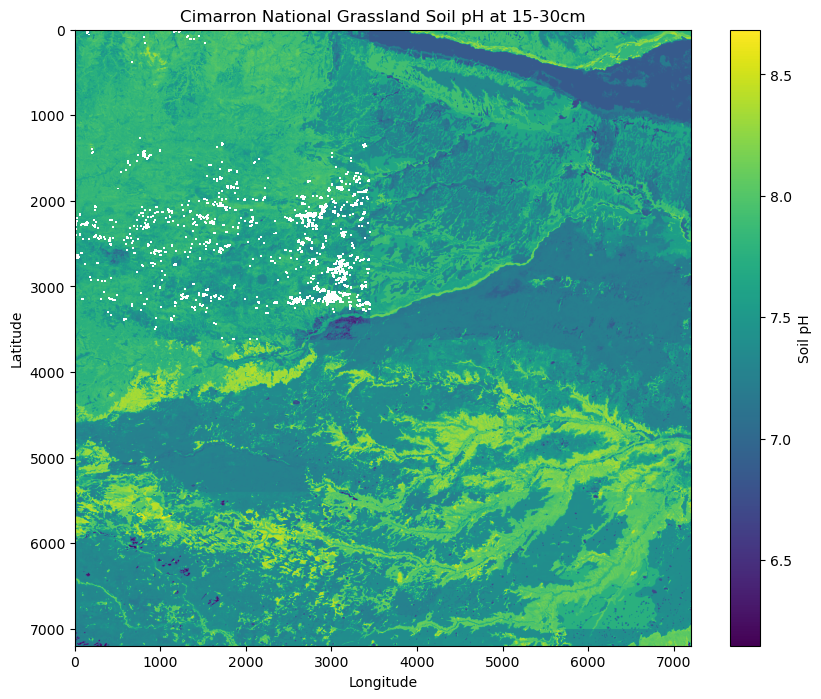

In [122]:
# Plot the Cimarron pH data
plt.figure(figsize=(10, 8))
plt.imshow(cim_merged_pH_da.data[0], cmap='viridis')
plt.colorbar(label='Soil pH')
plt.title('Cimarron National Grassland Soil pH at 15-30cm')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [123]:
# Define urls for soil pH data
paw_pH_urls = [
    "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/15_30/lat4041_lon-104-103.tif",
    "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/15_30/lat4041_lon-105-104.tif",
    "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/15_30/lat4142_lon-104-103.tif",
    "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/15_30/lat4142_lon-105-104.tif"
]

paw_pH_das = [rxr.open_rasterio(url, masked=True) for url in paw_pH_urls]
paw_merged_pH_da = rxrmerge.merge_arrays(paw_pH_das)

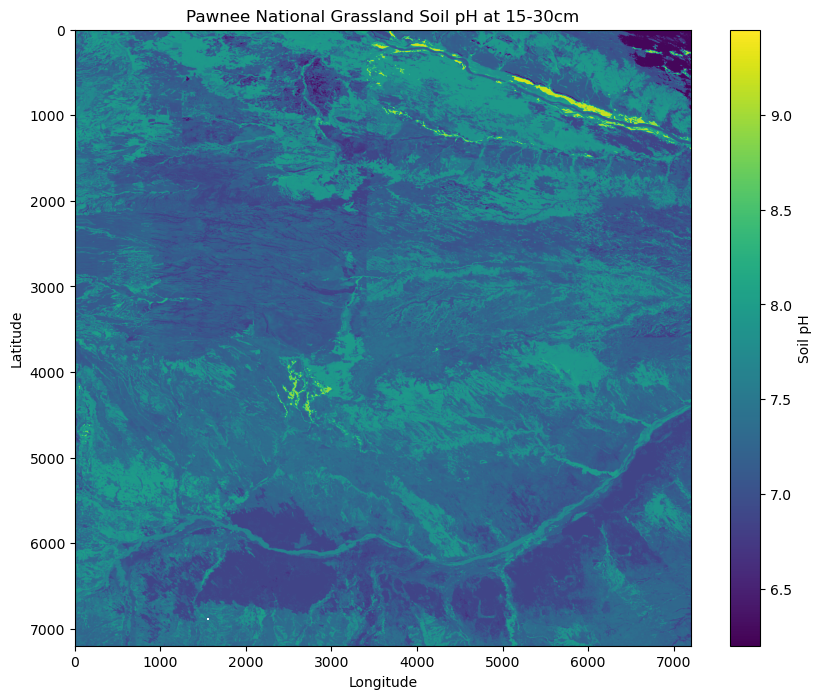

In [124]:
# Plot the Pawnee pH data
plt.figure(figsize=(10, 8))
plt.imshow(paw_merged_pH_da.data[0], cmap='viridis')
plt.colorbar(label='Soil pH')
plt.title('Pawnee National Grassland Soil pH at 15-30cm')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [130]:
# Initialize AppeearsDownloader for SRTM elevation data
ndvi_downloader = etapp.AppeearsDownloader(
    download_key="SRTM_DEM",
    ea_dir=project_dir,
    product="SRTMGL1_NC.003",
    layer="SRTMGL1_DEM",
    start_date="02-11",
    end_date="02-21",
    # recurring=False,
    # year_range=[2000, 2000],
    polygon=grasslands_gdf,
)

# # Download files if the download directory does not exist
if not os.path.exists(ndvi_downloader.data_dir):
    ndvi_downloader.download_files()

# ndvi_downloader

INFO:root:Submitting task request...
INFO:root:Logging into AppEEARS API...
INFO:root:Login successful. Auth Header: Bearer oTof2piRtj6_wv1OFxd8LJdyPzhyNKD9ySHyKEQMdZt9Zkd6NrduT1FM-EplHa36IPZFYSr4hB8-AwoB8KgsAQ


HTTPError: 400 Client Error: BAD REQUEST for url: https://appeears.earthdatacloud.nasa.gov/api/task